# Training of Neural Network for Novozyme Prediction
This NB allows you to test a NN model and get training infos
The different parts are:
- Simple train: train a NN based on the parameters in the config file
- Compute learning curve: mse for a dataset of 100/1000/3000/all rows
- Compute feature importance: use saved models and scalers to compute the avg mse with each features being randomized one at a time
- Compute submission: use saved models and scalers to compute the avg mse for each row of the submission dataset

Note: for hyper parameters optimization see the wandb_training.py script, in which we use wandb to sweep through a list of posssible hyper parameters

In [1]:
import copy
import torch
import numpy as np
import pandas as pd
import time
import tqdm

from training_utils.file_utils import (open_json, write_json, save_submission,
                                       log_kfold_training, log_learning_curve)
from training_utils.models import HybridNN
from training_utils.model_utils import *
from training_utils.training import k_fold_training


In [2]:
KEEP_MODELS = True

SIMPLE_TRAIN = True
COMPUTE_LEARNING_CURVE = False
COMPUTE_FEATURE_IMPORTANCE = False
COMPUTE_SUBMISSION = False

USE_KAGGLE_VOXEL_FOR_SUBMISSION = False

TRAINING_DIR = "outputs/hybrid_3/"

config = open_json("hybrid_nn_config.json")
features_dict = open_json(
    f"{config['dataset_dir']}/{config['features_name']}.json")
features, features_infos = compute_feature_list(config, features_dict)
device = get_device(config)
log_name = config["model_type"]

print(len(features))
print(len(features_infos["direct_features"]))
print(config["batch_size"])

cuda
150
150
1024


## Simple train


loaded 4215 data
no valid ksplit path given, doing ksplit without groups


100%|██████████| 5/5 [14:56<00:00, 179.39s/it]


logged training in ./outputs/hybrid_4


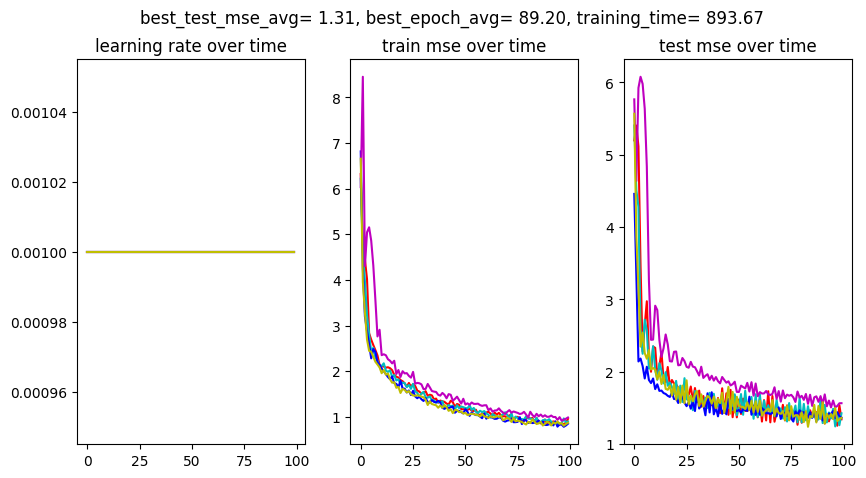

In [3]:
if SIMPLE_TRAIN:
    df = load_dataset(config, features, rm_nan=True)

    all_training_results = {"simple_train": [],
                            "total_training_time": 0}

    # add protein_index to the dataset and get ksplit:
    df = split_dataset(df, config)
    # training
    training_results = k_fold_training(
        df, config, features, features_infos, device, keep_models=KEEP_MODELS)

    # add training results to all the other ones
    all_training_results["simple_train"] = training_results
    
    # save results to output
    model = HybridNN(
        len(features_infos["direct_features"]), config)
    model_structure = str(model).replace(
        '(', '').replace(')', '').split('\n')
    dir_path = log_kfold_training(
        log_name, all_training_results, config, features, model_structure)

    if KEEP_MODELS:
        move_models_and_scalers(dir_path)

    print(f"logged training in {dir_path}")


## Find worst samples


In [4]:
if SIMPLE_TRAIN:
    WORST_SAMPLES_DIFF_THRESHOLD = 7.5
    worst_of_the_worst = []
    # WORST_SAMPLES_DIFF_THRESHOLD = 1
    for res in all_training_results.get("simple_train"):
        worst_samples = res.get("worst_samples")
        worst_of_the_worst += [record for record in worst_samples if record["diff"]
                               > WORST_SAMPLES_DIFF_THRESHOLD]

    print(len(worst_of_the_worst))
    write_json("worst_samples.json", worst_of_the_worst)


1


## Learning Curve


In [5]:
if COMPUTE_LEARNING_CURVE:
    df = load_dataset(config, features)

    # plot the learning curve of the model
    # ie. the avg mse when df has 10, 100, 1000 elements
    # len(df) = 5k
    num_rows = [100, 1000, 3000, len(df)]
    all_training_results = {"training_by_num_rows": [],
                            "learning_curve": {"num_rows": num_rows,
                                               "train_mse": [],
                                               "test_mse": []
                                               },
                            "total_training_time": 0
                            }

    t0 = time.time()
    for n in num_rows:
        print(f"training on {n} rows from the dataset")
        df_n_rows = df.sample(n)
        # add protein_index to the dataset and get ksplit:
        df_n_rows, ksplit = split_dataset(df_n_rows, config)
        training_results = k_fold_training(
            df_n_rows, ksplit, config, features, features_infos, device)

        # add training results to all the other ones
        all_training_results["training_by_num_rows"].append(training_results)
        # compute avg_mse and time
        train_mse = sum(x["train_mse"]
                        for x in training_results)/config["kfold"]
        test_mse = sum(x["test_mse"]
                       for x in training_results)/config["kfold"]
        training_time = sum(x["time"] for x in training_results)

        # update result variables
        all_training_results["total_training_time"] += training_time
        all_training_results["learning_curve"]["train_mse"].append(train_mse)
        all_training_results["learning_curve"]["test_mse"].append(test_mse)

    total_time = time.time()-t0
    print(f"total_training_time= {all_training_results['total_training_time']:.2f}, {total_time= :.2f}, \
        training_time: {(all_training_results['total_training_time']/total_time)*100:.2f}% of total time")


In [6]:
if COMPUTE_LEARNING_CURVE:
    # save results to output
    model = HybridNN(
        len(features_infos["direct_features"]), config)
    model_structure = str(model).replace('(', '').replace(')', '').split('\n')
    dir_path = log_learning_curve(
        log_name, all_training_results, config, features, model_structure)
    print(f"logged training in {dir_path}")


## Feature Importance


In [7]:
if COMPUTE_FEATURE_IMPORTANCE:
    """you need to provide a dir_path to a """
    # all_training_results[feature1]: result obtained when df[feature1] = random
    all_training_results = {}
    for x in range(5):
        dir_path = f"./outputs/hybrid_{x+8}/"
        print(dir_path)


        df = load_dataset(config, features, rm_nan=True)
        model_list, scaler_list = load_models_and_scalers(dir_path)
        training_results = open_json(dir_path+"results.json")
        # 1. we already trained k models using all features:
        df = split_dataset(df, config)

        # compute mse (with no feature randomized)
        none_random_train_mse = sum(x['train_mse']
                                    for x in training_results["simple_train"])/config['kfold']
        none_random_test_mse = sum(x['test_mse']
                                for x in training_results["simple_train"])/config['kfold']
        all_training_results["none_randomized"] = {
            "train_mse": none_random_train_mse, "test_mse": none_random_test_mse}

        # 2. for each feature we take the df, randomize the feature column, then compute the new mse score with each model
        print("now testing with random features")
        for feature in tqdm.tqdm(features):
            # create a copy of the dataset with the feature column being random
            df_random = copy.deepcopy(df)
            df_random[feature] = np.random.uniform(
                low=df[feature].min(), high=df[feature].max(), size=df_random.shape[0])
            training_results = []

            # evaluate all model on this new dataset
            for k in range(config["kfold"]):
                # we get the same ksplit as during training as we already added the kfold column to df
                train = list(range(config["kfold"]))
                test = [train.pop(k)]
                df_train = df_random[df_random["kfold"].isin(train)]
                df_test = df_random[df_random["kfold"].isin(test)]
                model = model_list[k]  # model result from the training
                dataset_train_scaler = scaler_list[k]  # scaler from training

                # we load the data for evaluation
                X_train_voxel, X_train_features, y_train = prepare_eval_data(
                    df_train, config, features, features_infos, dataset_train_scaler)
                X_test_voxel, X_test_features, y_test = prepare_eval_data(
                    df_test, config, features, features_infos, dataset_train_scaler)

                # Evaluate this model:
                model.eval()
                with torch.set_grad_enabled(False):
                    train_mse, _ = evaluate_model(
                        X_train_voxel, X_train_features, y_train, model, device)
                    test_mse, _ = evaluate_model(
                        X_test_voxel, X_test_features, y_test, model, device)
                    # print(f"MSE obtained for kfold {k}: {mse}")
                    results = {
                        "train_mse": train_mse,
                        "test_mse": test_mse
                    }
                    training_results.append(results)

            # compute avg_mse
            train_mse = sum(x['train_mse']
                            for x in training_results)/config['kfold']
            test_mse = sum(x['test_mse']
                        for x in training_results)/config['kfold']
            # add training results to all the other ones
            all_training_results[feature] = {
                "train_mse": train_mse, "test_mse": test_mse,
                "delta_train_mse": train_mse-none_random_train_mse,
                "delta_test_mse": test_mse-none_random_test_mse,
            }

        # rank results
        ranked_delta_test_mse = [[x, all_training_results[x].get(
            "delta_test_mse", 0)] for x in all_training_results.keys()]
        ranked_delta_test_mse.sort(key=lambda x: x[1], reverse=True)
        ranked_delta_test_mse = {x[0]: x[1] for x in ranked_delta_test_mse}
        write_json(f"{dir_path}{log_name}_feature_importance.json",
                {"ranked_delta_test_mse": ranked_delta_test_mse,
                    "all_training_results": all_training_results})


In [8]:
if COMPUTE_FEATURE_IMPORTANCE:
    all_feature_importance_by_category = {}
    for x in range(5):
        dir_path = f"./outputs/hybrid_{x+8}/"
        print(dir_path)
        ranked_delta_test_mse = open_json(
            f"{dir_path}{log_name}_feature_importance.json")["ranked_delta_test_mse"]
        feature_importance_by_category = {}
        for k, sublist in features_dict.items():
            total = 0
            cat = {}
            for feature in sublist:
                if feature in ranked_delta_test_mse:
                    value = ranked_delta_test_mse[feature]
                    total += value
                    cat[feature] = value 
            cat["sum_importances"] = total
            feature_importance_by_category[k] = cat
        write_json(f"{dir_path}feature_importance_by_category.json",
                feature_importance_by_category)



# Predicting on submission


In [9]:
if COMPUTE_SUBMISSION:
    dir_path = TRAINING_DIR
    submission_df = pd.read_csv(
        f"{config['dataset_dir']}/submission_with_voxel_from_kaggle_filled_nan.csv")

    if USE_KAGGLE_VOXEL_FOR_SUBMISSION:
        submission_df["direct_voxel_features"] = submission_df["kaggle_voxel_path"].apply(
            np.load)
    else:
        # load voxel directly in df
        submission_df["direct_voxel_features"] = submission_df["direct_voxel_path"].apply(
            np.load)
    results = []

    model_list, scaler_list = load_models_and_scalers(dir_path)

    for k in range(len(model_list)):
        model = model_list[k]  # model result from the training
        dataset_train_scaler = scaler_list[k]  # scaler from training
        X_voxel_features, X_features, _ = prepare_eval_data(submission_df, config,
                                                            features, features_infos,
                                                            dataset_train_scaler,
                                                            submission=True)

        # Evaluate this model:
        model.eval()
        with torch.set_grad_enabled(False):
            X_voxel_features = X_voxel_features.to(device)
            X_features = X_features.to(device)
            y_test = model(X_voxel_features, X_features)
            results.append(y_test.cpu().detach().numpy())

    submission = pd.DataFrame(columns=["seq_id", "tm"])
    submission["seq_id"] = submission_df["seq_id"]
    submission["tm"] = np.mean(np.array(results), axis=0)
    print(submission.head())
    save_path = save_submission(submission, log_name, TRAINING_DIR)
    print(f"{save_path=}")
